# 2D slopes

QG theory suggests that the slopes/aspect ratio of tracer filaments would go like N/f:
\begin{equation}
\frac{|\phi_z|}{|\phi_x|} = N/f
\end{equation}
for smoothhy varying background gradients (which is the case for our region). 
(Slope is like $dz/dx$, which will go like f/N). 

In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import xrft 

import gsw

In [2]:
import matplotlib
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
ds_659_rho = xr.open_dataset('data/sg_O2_659_isopycnal_grid_4m_27_sept_2021.nc')
ds_660_rho = xr.open_dataset('data/sg_O2_660_isopycnal_grid_4m_27_sept_2021.nc')

# compute spice 
# Pick constant alpha and beta for convenience (can always update later)
alpha_659 = gsw.alpha(ds_659_rho.SA, ds_659_rho.CT, ds_659_rho.ctd_pressure)
alpha_660 = gsw.alpha(ds_660_rho.SA, ds_660_rho.CT, ds_660_rho.ctd_pressure)
#alpha = 8.3012133e-05
#beta  = 0.00077351

#
dCT_659 = ds_659_rho.CT  - ds_659_rho.CT.mean('dives')
dSA_659 = ds_659_rho.SA  - ds_659_rho.SA.mean('dives')

ds_659_rho['Spice'] = (2*alpha_659*dCT_659).rename('Spice')

# remove a mean per isopycnal
dCT_660 = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA_660 = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

ds_660_rho['Spice'] = (2*alpha_660*dCT_660).rename('Spice')

In [4]:
from scipy import interpolate

In [5]:
def interp_distance(ds, var, vert_axis = 'ctd_pressure'): 

    #print (ds.longitude.mean(vert_axis))
    distance = np.cumsum(gt.utils.distance(ds.longitude.mean(vert_axis), 
                                           ds.latitude.mean(vert_axis)))
    
    #print(distance)
    dist_grid = np.arange(0, distance.max(), 500)

    for i in range(len(ds[vert_axis])): 
        
        #ds_temp = ds.isel(ctd_pressure=i) # would be nice if this was indexed without the hard coding
         
        #data = ds_temp[var].values
        
        ds_temp = ds[var][i,:]
        data = ds_temp.values
        
        f = interpolate.interp1d(distance, data, fill_value=np.nan)
        
        var_int = f(dist_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["distance"],
                                 coords={"distance": dist_grid, vert_axis: ds_temp[vert_axis]}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim=vert_axis)
        
    return da_var_int
            

In [6]:
ds_659_rho_dist = xr.merge( [#interp_distance(ds_659_rho.where(~np.isnan(ds_659_rho.longitude.mean('rho_grid')), drop=True), 'CT', 'rho_grid'), 
                             #interp_distance(ds_659_rho.where(~np.isnan(ds_659_rho.longitude.mean('rho_grid')), drop=True), 'SA', 'rho_grid'), 
                             interp_distance(ds_659_rho.where(~np.isnan(ds_659_rho.longitude.mean('rho_grid')), drop=True), 'Spice', 'rho_grid'), 
                             interp_distance(ds_659_rho.where(~np.isnan(ds_659_rho.longitude.mean('rho_grid')), drop=True), 'ctd_pressure', 'rho_grid')] )

In [7]:
ds_660_rho_dist = xr.merge( [#interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'CT', 'rho_grid'), 
                             #interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'SA', 'rho_grid'), 
                             interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'Spice', 'rho_grid'), 
                             interp_distance(ds_660_rho.where(~np.isnan(ds_660_rho.longitude.mean('rho_grid')), drop=True), 'ctd_pressure', 'rho_grid')] )

In [8]:
ds_660_rho_dist

<xarray.Dataset>
Dimensions:       (distance: 3407, rho_grid: 901)
Coordinates:
  * distance      (distance) float64 0.0 500.0 1e+03 ... 1.702e+06 1.703e+06
  * rho_grid      (rho_grid) float64 26.9 26.9 26.9 26.9 ... 27.8 27.8 27.8 27.8
Data variables:
    Spice         (rho_grid, distance) float64 2.913e-05 2.701e-05 ... nan nan
    ctd_pressure  (rho_grid, distance) float64 16.22 18.29 17.45 ... nan nan nan

### N2 calculation 

$$N^2 = db/dz$$

where $b = -g \rho ' / \rho _0$. 



In [26]:
g = 9.81
rho0 = 1000
b = - ds_660_rho_dist.rho_grid * g /rho0

In [57]:
f = 2*2*np.pi/24/3600*np.sin(55 * np.pi/180)
f

0.0001191408353940443

In [33]:
N2_659 = -b.diff('rho_grid')/ ds_659_rho_dist.ctd_pressure.diff('rho_grid')
N2_660 = -b.diff('rho_grid')/ ds_660_rho_dist.ctd_pressure.diff('rho_grid')

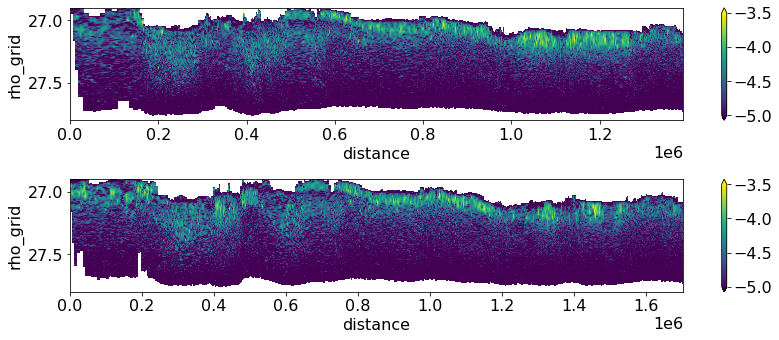

In [37]:
plt.figure(figsize=(12, 5))

plt.subplot(211)
np.log10(N2_659).plot(vmin=-5, vmax=-3.5)
plt.gca().invert_yaxis()

plt.subplot(212)
np.log10(N2_660).plot(vmin=-5, vmax=-3.5)
plt.gca().invert_yaxis()

plt.tight_layout()

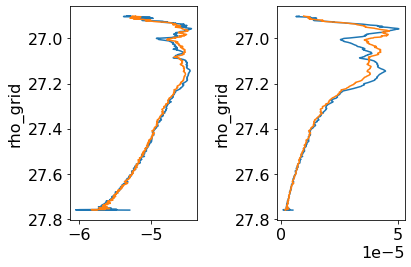

In [43]:
plt.subplot(121)
np.log10(N2_659).mean('distance').plot(y='rho_grid')
np.log10(N2_660).mean('distance').plot(y='rho_grid')
plt.gca().invert_yaxis()

plt.subplot(122)
N2_659.mean('distance').plot(y='rho_grid')
N2_660.mean('distance').plot(y='rho_grid')
plt.gca().invert_yaxis()

plt.tight_layout()

In [9]:
# Function that regrids a single dive 
# Will be rung in a loop to do interpolation for all dives.

def func_var_int_pmean(ds, Pmean_smooth_dist): 
    Pmean_grid = np.linspace(0,1000,501)
    
    Pmean = Pmean_smooth_dist
 
    ds_nonan = ds.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    Pmean_nonan = Pmean.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'distance'],
                        coords = {'Pmean': Pmean_grid, 'distance': [ds.distance.values]})
    

In [48]:
# For 659
time_ind = 0

Pmean_smooth = ds_659_rho_dist.ctd_pressure.mean('distance').rolling(rho_grid= 30, center=True).mean().sel(rho_grid=slice(27.2, 27.75))

N2_on_Pmean_659 = func_var_int_pmean(N2_659.isel(distance=0), Pmean_smooth)

spice_on_Pmean_659 = func_var_int_pmean(ds_659_rho_dist.Spice.isel(distance=0), Pmean_smooth)

for dist_ind in range(1, len(ds_659_rho_dist.distance)):
    if np.mod(dist_ind, 400)==0:
        print(dist_ind)
    spice_on_Pmean_659 = xr.concat([spice_on_Pmean_659, 
                                func_var_int_pmean(ds_659_rho_dist.Spice.isel(distance=dist_ind), Pmean_smooth)],
                                dim='distance')
    
    N2_on_Pmean_659 = xr.concat([N2_on_Pmean_659, 
                                func_var_int_pmean(N2_659.isel(distance=dist_ind), Pmean_smooth)],
                                dim='distance')    

400
800
1200
1600
2000
2400


In [52]:
# For 660 
time_ind = 0

Pmean_smooth = ds_660_rho_dist.ctd_pressure.mean('distance').rolling(rho_grid= 30, center=True).mean().sel(rho_grid=slice(27.2, 27.75))

N2_on_Pmean_660 = func_var_int_pmean(N2_660.isel(distance=0), Pmean_smooth)
spice_on_Pmean_660 = func_var_int_pmean(ds_660_rho_dist.Spice.isel(distance=0), Pmean_smooth)

for dist_ind in range(1, len(ds_660_rho_dist.distance)):
    if np.mod(dist_ind, 400)==0:
        print(dist_ind)
    spice_on_Pmean_660 = xr.concat([spice_on_Pmean_660, 
                                func_var_int_pmean(ds_660_rho_dist.Spice.isel(distance=dist_ind), Pmean_smooth)],
                                dim='distance')
    N2_on_Pmean_660 = xr.concat([N2_on_Pmean_660, 
                                func_var_int_pmean(N2_660.isel(distance=dist_ind), Pmean_smooth)],
                                dim='distance')        

400
800
1200
1600
2000
2400
2800
3200


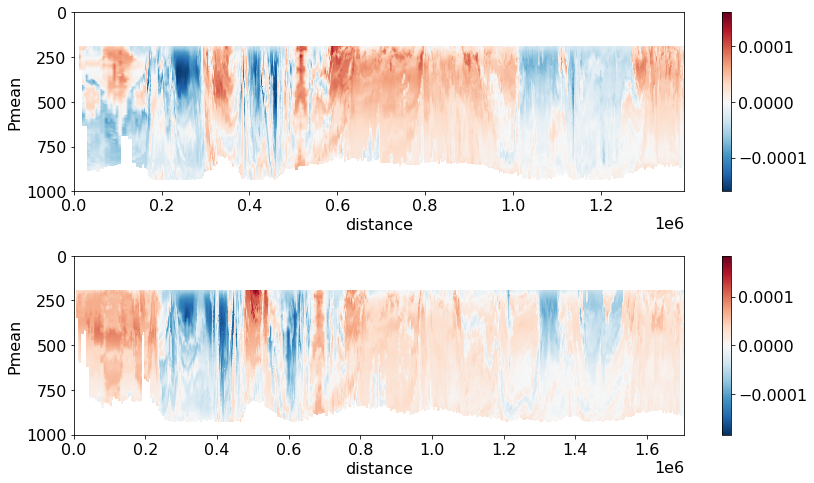

In [25]:
plt.figure(figsize=(12, 7))

plt.subplot(211)
spice_on_Pmean_659.plot()
plt.gca().invert_yaxis()

plt.subplot(212)
spice_on_Pmean_660.plot()
plt.gca().invert_yaxis()

plt.tight_layout()

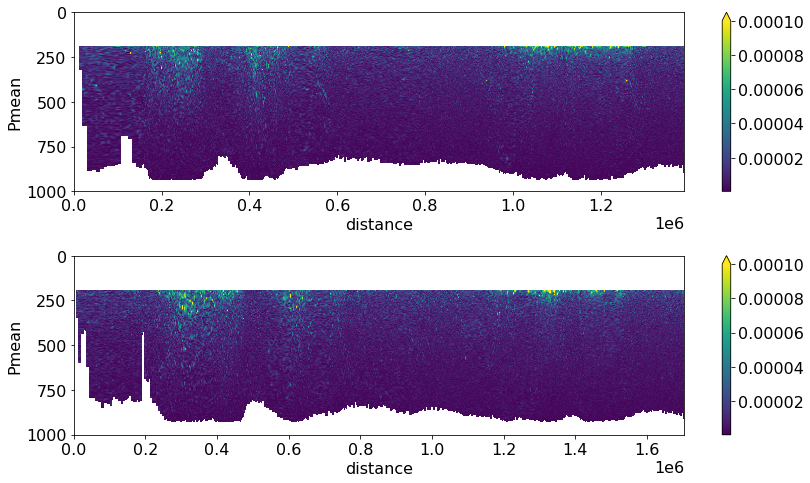

In [55]:
plt.figure(figsize=(12, 7))

plt.subplot(211)
N2_on_Pmean_659.plot(vmax=1e-4)
plt.gca().invert_yaxis()

plt.subplot(212)
N2_on_Pmean_660.plot(vmax=1e-4)
plt.gca().invert_yaxis()

plt.tight_layout()

In [13]:
dSdx_659 = np.abs(spice_on_Pmean_659.diff('distance')/ spice_on_Pmean_659.distance.diff('distance'))
dSdz_659 = np.abs(spice_on_Pmean_659.diff('Pmean')/ spice_on_Pmean_659.Pmean.diff('Pmean'))

dSdx_660 = np.abs(spice_on_Pmean_660.diff('distance')/ spice_on_Pmean_660.distance.diff('distance'))
dSdz_660 = np.abs(spice_on_Pmean_660.diff('Pmean')/ spice_on_Pmean_660.Pmean.diff('Pmean'))

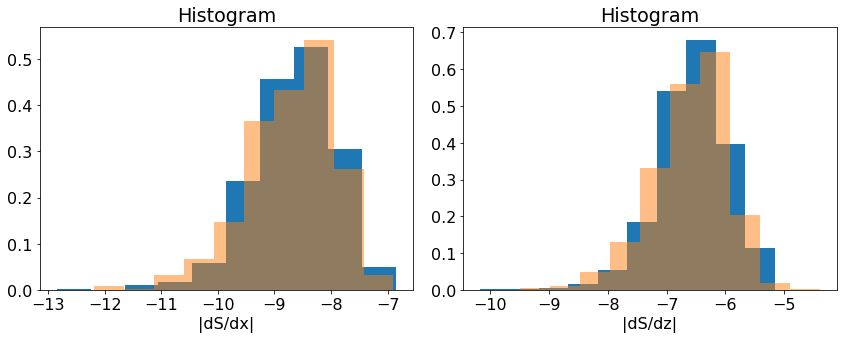

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
np.log10(dSdx_659).sel(Pmean=400, method='nearest').plot.hist(density=True)
np.log10(dSdx_660).sel(Pmean=400, method='nearest').plot.hist(alpha=0.5, density=True)
plt.xlabel('|dS/dx|')

plt.subplot(122)
np.log10(dSdz_659).sel(Pmean=400, method='nearest').plot.hist(density=True)
np.log10(dSdz_660).sel(Pmean=400, method='nearest').plot.hist(alpha=0.5, density=True)
plt.xlabel('|dS/dz|')

plt.tight_layout()

In [86]:
Nbyf = ( 0.5*(N2_on_Pmean_659 + N2_on_Pmean_660).mean('distance'))**0.5 /f

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


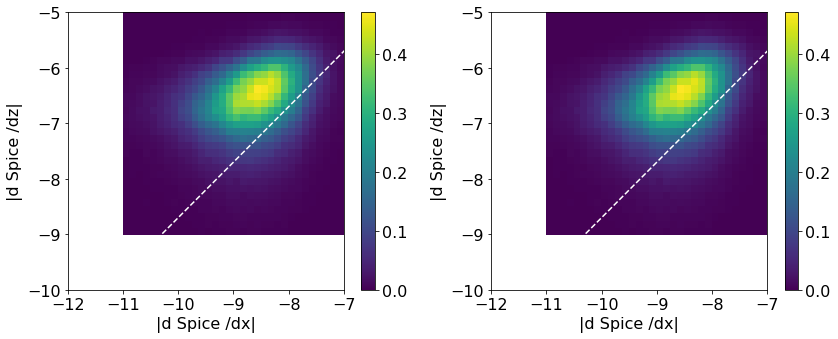

In [102]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
H_659 , xedges, yedges = np.histogram2d(np.log10(dSdx_659[:-1,:].sel(Pmean=slice(200, 750)).values.reshape(-1)), np.log10(dSdz_659[:, :-1].sel(Pmean=slice(200, 750)).values.reshape(-1)),
           bins=[np.linspace(-11, -6, 41), np.linspace(-9, -4, 40)], density=True   );

plt.pcolormesh(xedges[:-1], yedges[:-1], H_659.T)

plt.plot(xedges, xedges + np.log10(20),'--', color='w')

plt.colorbar()

plt.axis([-12, -7, -10, -5])

plt.xlabel('|d Spice /dx|')
plt.ylabel('|d Spice /dz|')

plt.subplot(122)
H_660 , xedges, yedges = np.histogram2d(np.log10(dSdx_659[:-1,:].sel(Pmean=slice(200, 750)).values.reshape(-1)), np.log10(dSdz_659[:, :-1].sel(Pmean=slice(200, 750)).values.reshape(-1)),
           bins=[np.linspace(-11, -6, 41), np.linspace(-9, -4, 40)], density=True   );

plt.pcolormesh(xedges[:-1], yedges[:-1], H_660.T)

plt.plot(xedges, xedges + np.log10(20),'--', color='w')

plt.colorbar()

plt.axis([-12, -7, -10, -5])

plt.xlabel('|d Spice /dx|')
plt.ylabel('|d Spice /dz|')

plt.tight_layout()

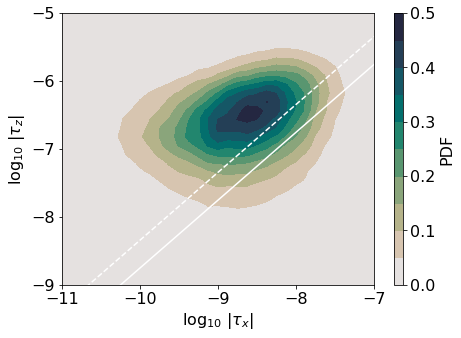

In [118]:
plt.figure(figsize=(7, 5))
plt.subplot(111)

plt.contourf(xedges[:-1], yedges[:-1], 0.5*(H_659 + H_660).T, levels=np.linspace(0, 0.5,11), cmap=cmo.rain)

plt.plot(xedges, xedges + np.log10(Nbyf.sel(Pmean=slice(200, 750)).max().values),'--', color='w')
plt.plot(xedges, xedges + np.log10(Nbyf.sel(Pmean=slice(200, 750)).min().values),'-', color='w')

plt.colorbar(aspect=30, label='PDF')

plt.axis([-11, -7, -9, -5])

plt.yticks(ticks=[-9, -8, -7, -6, -5])

plt.xlabel(r'log$_{10}$ $|\tau _x|$')
plt.ylabel(r'log$_{10}$ $|\tau _z|$')

plt.savefig('./figures/figures_slope_pdf.pdf')

In [122]:
AR_659 = dSdz_659.mean('distance') / dSdx_659.mean('distance')
AR_660 = dSdz_660.mean('distance') / dSdx_660.mean('distance')

AR = 0.5* (AR_659 + AR_660)



Text(0.5, 0, 'Aspect Ratio')

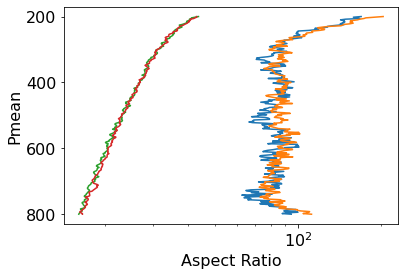

In [63]:
(AR_659).sel(Pmean=slice(200,800)).plot(y='Pmean')
(AR_660).sel(Pmean=slice(200,800)).plot(y='Pmean')

( (N2_on_Pmean_659**0.5) /f).sel(Pmean=slice(200, 800)).mean('distance').plot(y='Pmean')
( (N2_on_Pmean_660**0.5) /f).sel(Pmean=slice(200, 800)).mean('distance').plot(y='Pmean')

plt.gca().invert_yaxis()

plt.xscale('log')

plt.xlabel('Aspect Ratio')

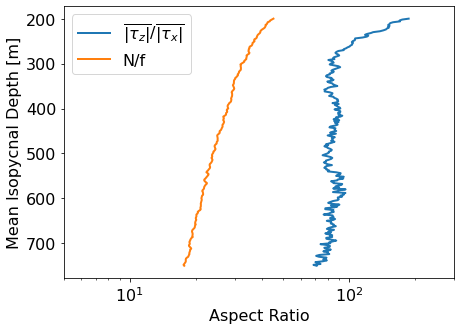

In [105]:
plt.figure(figsize=(7, 5))
AR.sel(Pmean=slice(200,750)).plot(y='Pmean', label=r'$\overline{| \tau _z|} / \overline{| \tau _x|}$', linewidth=2.)
Nbyf.sel(Pmean=slice(200, 750)).plot(y='Pmean', label='N/f', linewidth=2.)
# ( (N2_on_Pmean_660**0.5) /f).sel(Pmean=slice(200, 800)).plot(y='Pmean')

plt.gca().invert_yaxis()

plt.xscale('log')
plt.legend()

plt.xlabel('Aspect Ratio')
plt.ylabel('Mean Isopycnal Depth [m]')
plt.xlim([5, 300])

plt.savefig('./figures/figures_aspect_ratio.pdf')